<a href="https://colab.research.google.com/github/mmaghajani/recommender-with-tf-sample/blob/main/amazon_us_reviews_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q --upgrade tensorflow-datasets

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
ratings_dataset, ratings_datasets_info = tfds.load(
    name='amazon_us_reviews/Mobile_Electronics_v1_00',
    with_info=True,
    split='train',
)

In [6]:
assert isinstance(ratings_dataset, tf.data.Dataset)

In [7]:
len(ratings_dataset)

104975

In [8]:
ratings_dataset_head = ratings_dataset.take(5)

for rating in ratings_dataset_head.as_numpy_iterator():
  print(rating)

{'data': {'customer_id': b'20980074', 'helpful_votes': 0, 'marketplace': b'US', 'product_category': b'Mobile_Electronics', 'product_id': b'B00D1847NE', 'product_parent': b'274617424', 'product_title': b'Teenage Mutant Ninja Turtles Boombox CD Player with Text Display, AM/FM Stereo Radio, Repeat Function', 'review_body': b'Does not work', 'review_date': b'2015-01-09', 'review_headline': b'One Star', 'review_id': b'R1OVS0D6SEXPW7', 'star_rating': 1, 'total_votes': 0, 'verified_purchase': 0, 'vine': 1}}
{'data': {'customer_id': b'779273', 'helpful_votes': 0, 'marketplace': b'US', 'product_category': b'Mobile_Electronics', 'product_id': b'B00KMO6DYG', 'product_parent': b'397452138', 'product_title': b'4 Gauge Amp Kit Amplifier Install Wiring Complete 4 Ga Installation Cables 2500W', 'review_body': b'This is a great wiring kit i used it to set up my Pyle 2000 watt amp to 2 alpine subs and worked just fine. im not sure about the power cord and its length because my battery is in the back but

In [9]:
import time
import datetime

ratings_dataset = ratings_dataset.map(
    lambda rating: {'data': {
        'customer_id': rating['data']['customer_id'],
        'product_id': rating['data']['product_id'],
        'product_title': rating['data']['product_title'],
        'star_rating': rating['data']['star_rating'],
        # 'timestamp': time.mktime(datetime.datetime.strptime(rating['data']['review_date'].value, "%Y-%m-%d").timetuple()),

    }}
)

tfds.as_dataframe(ds=ratings_dataset.take(5), ds_info=ratings_datasets_info)

,data/customer_id,data/product_id,data/product_title,data/star_rating
0,b'20980074',b'B00D1847NE',"b'Teenage Mutant Ninja Turtles Boombox CD Player with Text Display, AM/FM Stereo Radio, Repeat Function'",1
1,b'779273',b'B00KMO6DYG',b'4 Gauge Amp Kit Amplifier Install Wiring Complete 4 Ga Installation Cables 2500W',4
2,b'15410531',b'B000GWLL0K',b'Travel Wall Charger fits Creative Zen Vision / Vision:M / Sleek / Sleek Photo...',5
3,b'27389005',b'B008L3JE6Y',"b'High Grade Robust 360\xc2\xb0 Adjustable Car Windshield Swivel Suction Mount with Low Profile Car Kit Holder for 7"" Tablet PCs'",5
4,b'2663569',b'B00GHZS4SC',"b'HDE Multifunctional Bluetooth FM Audio Car Kit - Handsfree Calling, Phone Charger, USB/SD/MMC FM Transmitter for MP3 with Remote'",3


In [10]:
ratings_datasets_info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    full_name='amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0',
    description="""
    Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promoti

In [11]:

ratings_datasets_info.splits['train'].num_examples

104975

### Train/Test Split

In [12]:
tf.random.set_seed(42)
ratings_dataset_shuffled = ratings_dataset.shuffle(
    buffer_size=104_975,
    seed=42,
    reshuffle_each_iteration=False,
)

In [13]:
ratings_trainset = ratings_dataset_shuffled.take(90_000)
ratings_testset = ratings_dataset_shuffled.skip(90_000)

In [14]:
len(ratings_trainset), len(ratings_testset)

(90000, 14975)

### End-to-end Preprocessing

In [15]:
user_id_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['data']['customer_id']
    )
)

In [16]:
print(
    user_id_lookup_layer.get_vocabulary(),
)

['[UNK]', '15127646', '29514513', '12259799', '53037408', '52460215', '53090839', '49675502', '43856165', '34408569', '32038204', '19803990', '51346302', '50027179', '45070473', '38773014', '34645354', '17957446', '11995502', '53017806', '51666042', '44834233', '30208851', '7394955', '52874175', '52803739', '52801489', '52321161', '51949299', '47618784', '39923711', '38056064', '33107350', '28171883', '27966208', '26184612', '24745118', '23324858', '21932728', '18212272', '17703766', '13069116', '1089565', '948409', '8953879', '52870270', '52455519', '52228204', '51963828', '51712970', '51321735', '50867619', '50699505', '49411358', '47916002', '46711885', '46587935', '43928522', '43748492', '43291581', '41922617', '41257300', '40577419', '40363986', '40062580', '39131117', '35130971', '34595860', '33983649', '32770247', '31481426', '31096617', '30592691', '29183692', '2830811', '27140716', '25845831', '24831002', '23943923', '2346648', '22429746', '22051093', '20737314', '20142644', '

In [17]:
user_id_embedding_dim = 32
user_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=user_id_lookup_layer.vocabulary_size(),
    output_dim=user_id_embedding_dim,
)
user_id_model = tf.keras.Sequential([
    user_id_lookup_layer,
    user_id_embedding_layer,                                      
])

In [18]:
product_id_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
product_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['data']['product_id']
    )
)

In [19]:
product_id_embedding_dim = 32
product_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=product_id_lookup_layer.vocabulary_size(),
    output_dim=product_id_embedding_dim,
)
product_id_model = tf.keras.Sequential([
    product_id_lookup_layer,
    product_id_embedding_layer,                                      
])

In [20]:
product_title_vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization()
product_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['data']['product_title']
    )
)

In [21]:
product_title_dim = 32
product_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(product_title_vectorization_layer.get_vocabulary()),
    output_dim=product_title_dim,
)

In [22]:
product_title_model = tf.keras.Sequential([
    product_title_vectorization_layer,
    product_title_embedding_layer,   
    tf.keras.layers.GlobalAveragePooling1D(),                   
])

### Query and Candidate Towers

In [23]:
query_tower = user_id_model
candidate_tower = product_id_model

In [24]:
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['data']['customer_id'],
        'product_id': rating['data']['product_id'],
    }
)

retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['data']['customer_id'],
        'product_id': rating['data']['product_id'],
    }
)

In [25]:
for row in retrieval_ratings_testset.take(5):
  print(row)

{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'52888377'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00BUFBQWU'>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'29510678'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00J7QNY7Y'>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'16838969'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B007WOKBRY'>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1361834'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00LG9DLX2'>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2065342'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00P0RBF5W'>}


In [26]:
!pip install -q scann tensorflow-recommenders
import tensorflow_recommenders as tfrs

#### Derive candidate corpus

In [27]:
df = tfds.as_dataframe(ds=ratings_dataset, ds_info=ratings_datasets_info)

In [28]:
product_ids = df['data/product_id'].unique()

In [29]:
candidates_corpus = tf.data.Dataset.from_tensor_slices(product_ids)

In [30]:
print(tfds.as_dataframe(candidates_corpus, ds_info=ratings_datasets_info))

                    
0      b'B00D1847NE'
1      b'B00KMO6DYG'
2      b'B000GWLL0K'
3      b'B008L3JE6Y'
4      b'B00GHZS4SC'
...              ...
25796  b'B005F790V8'
25797  b'B00SAVHKBI'
25798  b'B00KRL6Q46'
25799  b'B0088TFB4U'
25800  b'B004N6ZSX6'

[25801 rows x 1 columns]


In [31]:
for product in candidates_corpus.take(10):
  print(product)

tf.Tensor(b'B00D1847NE', shape=(), dtype=string)
tf.Tensor(b'B00KMO6DYG', shape=(), dtype=string)
tf.Tensor(b'B000GWLL0K', shape=(), dtype=string)
tf.Tensor(b'B008L3JE6Y', shape=(), dtype=string)
tf.Tensor(b'B00GHZS4SC', shape=(), dtype=string)
tf.Tensor(b'B00IMFYGKK', shape=(), dtype=string)
tf.Tensor(b'B0054TR5CS', shape=(), dtype=string)
tf.Tensor(b'B0050FXF52', shape=(), dtype=string)
tf.Tensor(b'B004JZ85AE', shape=(), dtype=string)
tf.Tensor(b'B0034DIZ4S', shape=(), dtype=string)


In [32]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=candidates_corpus.batch(128).map(
            candidate_tower
        )
    ),
)

In [33]:
class RetrievalModel(tfrs.models.Model):
  def __init__(self, query_model, candidate_model, retrieval_layer):
    super().__init__()
    self.query_model = query_model
    self.candidate_model = candidate_model
    self.retrieval_layer = retrieval_layer

  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features['product_id'])
    loss = self.retrieval_layer(query_embeddings, positive_candidate_embeddings)
    return loss

In [34]:
retrieval_model = RetrievalModel(query_tower, candidate_tower, retrieval_task_layer)
retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),

)

In [35]:
retrieval_ratings_trainset = retrieval_ratings_trainset.shuffle(90_000).batch(8192).cache()
retrieval_ratings_testset = retrieval_ratings_testset.batch(4096).cache()
history = retrieval_model.fit(
    retrieval_ratings_trainset,
    epochs=1,
    validation_data=retrieval_ratings_testset,
    validation_freq=1,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


11/11 [==============================] - 328s 28s/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0078 - factorized_top_k/top_10_categorical_accuracy: 0.0119 - factorized_top_k/top_50_categorical_accuracy: 0.0266 - factorized_top_k/top_100_categorical_accuracy: 0.0341 - loss: 73631.0000 - regularization_loss: 0.0000e+00 - total_loss: 73631.0000 - val_factorized_top_k/top_1_categorical_accuracy: 0.0024 - val_factorized_top_k/top_5_categorical_accuracy: 0.0179 - val_factorized_top_k/top_10_categorical_accuracy: 0.0297 - val_factorized_top_k/top_50_categorical_accuracy: 0.0493 - val_factorized_top_k/top_100_categorical_accuracy: 0.0626 - val_loss: 21217.0215 - val_regularization_loss: 0.0000e+00 - val_total_loss: 21217.0215


In [36]:

import matplotlib.pyplot as plt
import pandas as pd

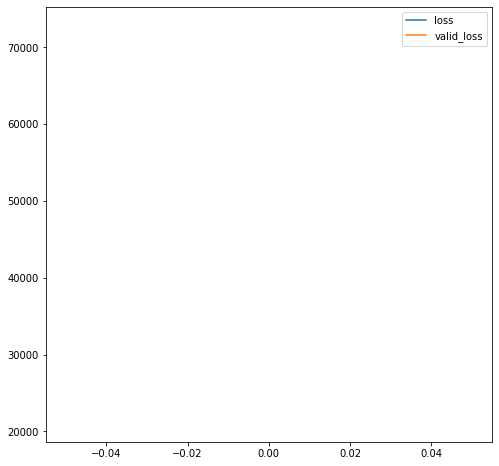

In [37]:

pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))


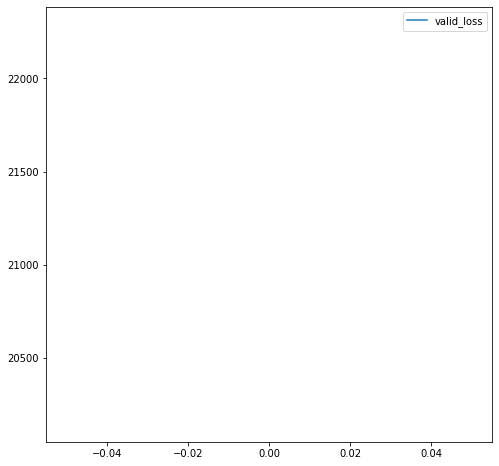

In [38]:
pd.DataFrame({
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))

In [40]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    retrieval_model.query_model
)

scann_layer.index(
    candidates_corpus.batch(100).map(
        retrieval_model.candidate_model
    ),
    candidates_corpus
)

user_id = '42'
afinity_scores, product_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {product_ids[0, :5]}")

Recommendations for user 42 using ScaNN: [b'B00S4FKHG0' b'B0083OOUZ6' b'B004IK5ZFI' b'B005FPU0NC' b'B00OIHXRS8']


In [41]:
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir:
  retrieval_model_path = os.path.join(tmp_dir, "retrieval_model")


scann_layer.save(
    retrieval_model_path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

INFO:tensorflow:Assets written to: /tmp/tmpsyp50emf/retrieval_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpsyp50emf/retrieval_model/assets


In [43]:

# Reload the saved model to confirm that it works correctly
reloaded_model = tf.keras.models.load_model(retrieval_model_path)
afinity_scores, product_ids = reloaded_model(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using reloaded saved model: {product_ids[0, :5]}")

Recommendations for user 42 using reloaded saved model: [b'B00S4FKHG0' b'B0083OOUZ6' b'B004IK5ZFI' b'B005FPU0NC' b'B00OIHXRS8']


### Ranking Model

In [53]:
class RankingModel(tfrs.models.Model):
  """MovieLens ranking model"""

  def __init__(self, query_model, candidate_model):
    super().__init__()

    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.rating_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ]
    )
    self.ranking_task_layer: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )


  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['data']['customer_id'])
    candidate_embeddings = self.candidate_model(features['data']["product_id"])
    rating_predictions = self.rating_model(
        tf.concat(
            [query_embeddings, candidate_embeddings],
            axis=1
        )
        # We could use `tf.keras.layers.Concatenate(axis=1)([x, y])`
    )

    loss = self.ranking_task_layer(
        predictions=rating_predictions,
        labels=features['data']["star_rating"]
    )
    return loss

In [54]:

ranking_model = RankingModel(query_tower, candidate_tower)

optimizer_step_size = 0.1
ranking_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [56]:

ranking_ratings_trainset = ratings_trainset.shuffle(90_000).batch(8192).cache()
ranking_ratings_testset = ratings_testset.batch(4096).cache()

history = ranking_model.fit(
    ranking_ratings_trainset,
    validation_data=ranking_ratings_testset,
    validation_freq=1,
    epochs=5,
)

Epoch 1/5
11/11 [==============================] - 8s 445ms/step - root_mean_squared_error: 1.5348 - loss: 2.3507 - regularization_loss: 0.0000e+00 - total_loss: 2.3507 - val_root_mean_squared_error: 1.5161 - val_loss: 2.3626 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.3626
Epoch 2/5
11/11 [==============================] - 1s 88ms/step - root_mean_squared_error: 1.5151 - loss: 2.2959 - regularization_loss: 0.0000e+00 - total_loss: 2.2959 - val_root_mean_squared_error: 1.5195 - val_loss: 2.3574 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.3574
Epoch 3/5
11/11 [==============================] - 1s 80ms/step - root_mean_squared_error: 1.5092 - loss: 2.2772 - regularization_loss: 0.0000e+00 - total_loss: 2.2772 - val_root_mean_squared_error: 1.5106 - val_loss: 2.3294 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.3294
Epoch 4/5
11/11 [==============================] - 1s 81ms/step - root_mean_squared_error: 1.5037 - loss: 2.2606 - regularization_loss:

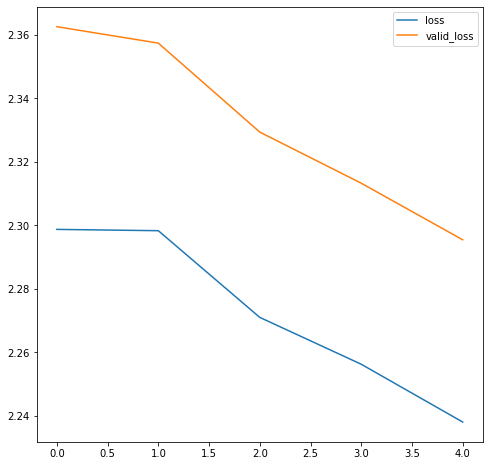

In [57]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))